---

# Analysis
---

## Data preparation

In [721]:
raw_df = pd.read_excel("raw_data.xlsx", index_col=None)
df = raw_df.copy()

#### Removing data Inconsistencies
The raw data has the following inconsistencies:
- The "Quantidade Vendida" value may be zero
- There are combinations of "Status do Pedido" and "Forma de Pagamento" that may be invalid:
    -  "Pago" with None
    -  "Cancelado" or "Aguardando Pagamento" with any other then None
- Added some None values on columns "Data da Venda", "Região", "Vendedor", "Produto" and "Status do Pedido"

In [722]:
# Removing rows where '"Quantidade Vendida" value 
df = df[df["Quantidade Vendida"] != 0]

# Removing invalid combination of "Status do Pedido" and "Forma de Pagamento"
df = df.drop(df[(df["Status do Pedido"]=="Pago") & (df["Forma de Pagamento"] is None)].index)

# Removing empty values on columns "Data da Venda", "Região", "Vendedor", "Produto" and "Status do Pedido"
df = df.dropna(subset=["Data da Venda", "Região", "Vendedor", "Produto", "Status do Pedido"])

# Removing duplicates values
df = df.drop_duplicates()

In [723]:
print(f"{(1-(df.shape[0] / raw_df.shape[0]))*100:.2f}% of rows were removed from dataset due inconsistencies")

14.70% of rows were removed from dataset due inconsistencies


---

## Data Analysis

#### Calculating the following KPIs
- Total Revenue
- Average ticket by client and product
- Faturamento por categoria de produto
- Percentual de pedidos cancelados e em atraso
- Ticket médio por forma de pagamento
- Variação percentual de vendas entre dois períodos (ex: comparar semestres, trimestres ou meses)

In [724]:
df.head()

,Data da Venda,Região,Vendedor,Produto,Categoria do Produto,Valor do Produto,Quantidade Vendida,Forma de Pagamento,Status do Pedido,Cliente_ID
1,02/12/2022 14:01,Nordeste,Cecília,Mochila Lenovo para notebook,Acessórios,150,7,Débito,Pago,15
2,26/09/2024 22:45,Sudeste,Artur,Tênis Nike Revolution,Vestuário,320,9,Crédito,Pago,74
3,14/02/2023 14:59,Sudeste,Laura,Jaqueta Corta Vento Adidas,Vestuário,450,8,Pix,Pago,55
8,22/11/2024 23:30,Nordeste,Artur,Smartphone Samsung A34,Telefonia,1799,2,Boleto,Aguardando Pagamento,3
9,26/10/2022 13:31,Sudeste,Laura,Relógio Smartwatch Xiaomi,Acessórios,480,6,Débito,Pago,42


In [725]:
df['Data da Venda'] = pd.to_datetime(df['Data da Venda'], format='%d/%m/%Y %H:%M')
df['Cliente_ID'] = df['Cliente_ID'].apply(lambda a: f"{a:03n}")
df["Valor da Venda"] = df["Valor do Produto"] * df["Quantidade Vendida"]
df_completed = df[df["Status do Pedido"]=="Pago"].copy()
total_revenue = df_completed["Valor da Venda"].sum()
print(f"Total revenue = R${total_revenue:,.2f}")

Total revenue = R$29,128,409.00


In [726]:
ticket_cliente = df_completed.groupby('Cliente_ID').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index()

ticket_cliente['ticket_medio'] = ticket_cliente['total_vendas'] / ticket_cliente['quantidade_vendas']
average_ticket_by_client = ticket_cliente['ticket_medio'].mean()
print(f"Average Ticket by Client = R${average_ticket_by_client:,.2f}")

Average Ticket by Client = R$4,873.22


In [727]:
ticket_produto = df_completed.groupby('Produto').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index()

ticket_produto['ticket_medio'] = round(ticket_produto['total_vendas'] / ticket_produto['quantidade_vendas'], 2)
average_ticket_by_product = ticket_produto['ticket_medio'].mean()
print(f"Average Ticket by product = R${average_ticket_by_product:,.2f}")

Average Ticket by product = R$7,321.38


In [728]:
ticket_cat_produto = df_completed.groupby('Categoria do Produto').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index()

ticket_cat_produto['ticket_medio'] = round(ticket_cat_produto['total_vendas'] / ticket_cat_produto['quantidade_vendas'], 2)
average_ticket_by_cat_product = ticket_cat_produto['ticket_medio'].mean()
print(f"Average Ticket by category product = R${average_ticket_by_cat_product:,.2f}")

Average Ticket by category product = R$5,777.20


## Some tables with the data

In [729]:
ticket_cat_produto.sort_values(by='ticket_medio')

,Categoria do Produto,total_vendas,quantidade_vendas,ticket_medio
7,Periféricos,741920,656,1130.98
9,Vestuário,1074530,724,1484.16
0,Acessórios,1125870,669,1682.91
2,Eletroportáteis,1332830,692,1926.05
10,Áudio,1772627,643,2756.81
5,Impressoras,1372140,310,4426.26
4,Esportes,3416193,479,7131.93
1,Eletrodomésticos,4139900,524,7900.57
6,Informática,4620152,509,9076.92
8,Telefonia,3846444,411,9358.74


In [730]:
df_venda_per_cat = df_completed.groupby('Categoria do Produto').agg(
    total_vendas=('Valor da Venda', 'sum'),
).sort_values(by="total_vendas", ascending=False)
df_venda_per_cat["formated"] = df_venda_per_cat["total_vendas"].apply(lambda a: f"R${a:,.2f}")
df_venda_per_cat

,total_vendas,formated
Categoria do Produto,,
Eletrônicos,5685803,"R$5,685,803.00"
Informática,4620152,"R$4,620,152.00"
Eletrodomésticos,4139900,"R$4,139,900.00"
Telefonia,3846444,"R$3,846,444.00"
Esportes,3416193,"R$3,416,193.00"
Áudio,1772627,"R$1,772,627.00"
Impressoras,1372140,"R$1,372,140.00"
Eletroportáteis,1332830,"R$1,332,830.00"
Acessórios,1125870,"R$1,125,870.00"


## Plots

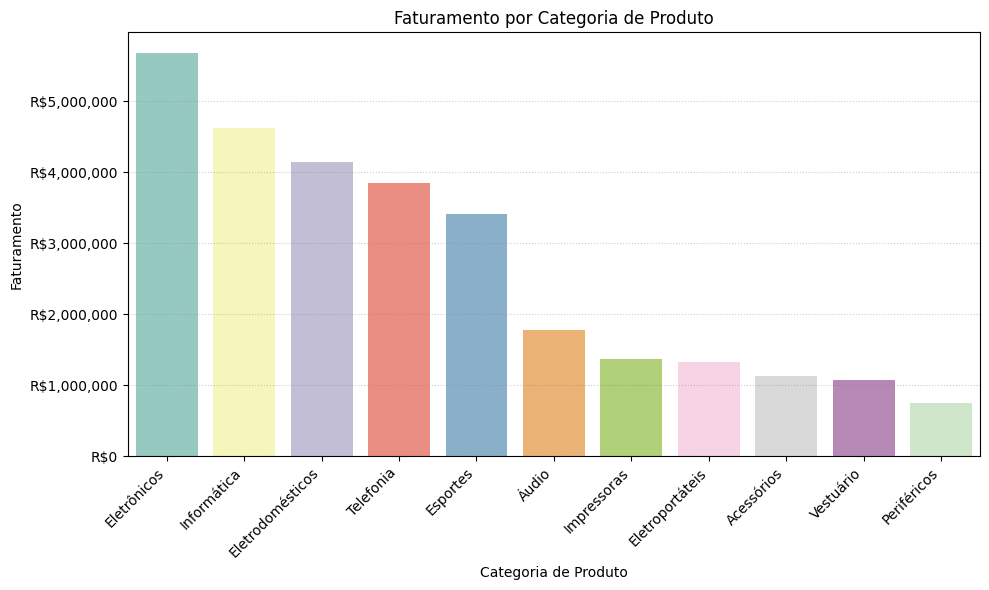

In [763]:
# Criar a paleta de cores usando Set3
palette = sns.color_palette("Set3", n_colors=df_venda_per_cat.shape[0])

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
ax=sns.barplot(
    data=df_venda_per_cat,
    x='Categoria do Produto',
    y='total_vendas',
    palette=palette,
    hue='Categoria do Produto',
)
plt.grid(True, linestyle=':', color='gray', alpha=0.4, axis='y')
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
plt.title('Faturamento por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Faturamento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/fat_cat.jpg', bbox_inches='tight')
plt.show()

In [764]:
df_completed.columns

Index(['Data da Venda', 'Região', 'Vendedor', 'Produto',
       'Categoria do Produto', 'Valor do Produto', 'Quantidade Vendida',
       'Forma de Pagamento', 'Status do Pedido', 'Cliente_ID',
       'Valor da Venda', 'Ano', 'Trimestre', 'AnoMes'],
      dtype='object')

In [765]:
ticket_pay_met = df_completed.groupby('Forma de Pagamento').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index()

ticket_pay_met['ticket_medio'] = round(ticket_pay_met['total_vendas'] / ticket_pay_met['quantidade_vendas'], 2)
average_ticket_pay_met = ticket_pay_met['ticket_medio'].mean()
print(f"Average Ticket by payment method = R${average_ticket_pay_met:,.2f}")

Average Ticket by payment method = R$4,859.10


In [766]:
df_not_completed = df["Status do Pedido"].isin(["Em Atraso", "Cancelado"])
not_completed = df_not_completed.sum() / df.shape[0] * 100
print(f"Percentage of cancelled or delayed orders: {not_completed:.2f}%")

Percentage of cancelled or delayed orders: 15.27%


In [767]:
ticket_forma_pagamento = df_completed.groupby('Forma de Pagamento').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index()

ticket_forma_pagamento['ticket_medio'] = round(ticket_forma_pagamento['total_vendas'] / ticket_forma_pagamento['quantidade_vendas'], 2)
average_ticket_by_pay_type = ticket_forma_pagamento['ticket_medio'].mean()

In [768]:
ticket_forma_pagamento

,Forma de Pagamento,total_vendas,quantidade_vendas,ticket_medio
0,Boleto,5922198,1164,5087.80
1,Crédito,5999176,1214,4941.66
2,Débito,5679339,1201,4728.84
3,Pix,5478081,1171,4678.12


In [769]:
df_completed['Ano'] = df_completed['Data da Venda'].dt.year
df_completed['Trimestre'] = df_completed['Data da Venda'].dt.quarter
vendas_trimestre = df_completed.groupby(['Ano', 'Trimestre'])['Valor da Venda'].sum().reset_index()
vendas_trimestre = vendas_trimestre.sort_values(by=['Ano', 'Trimestre'])
vendas_trimestre['Variacao'] = round(vendas_trimestre['Valor da Venda'].pct_change() * 100, 2)

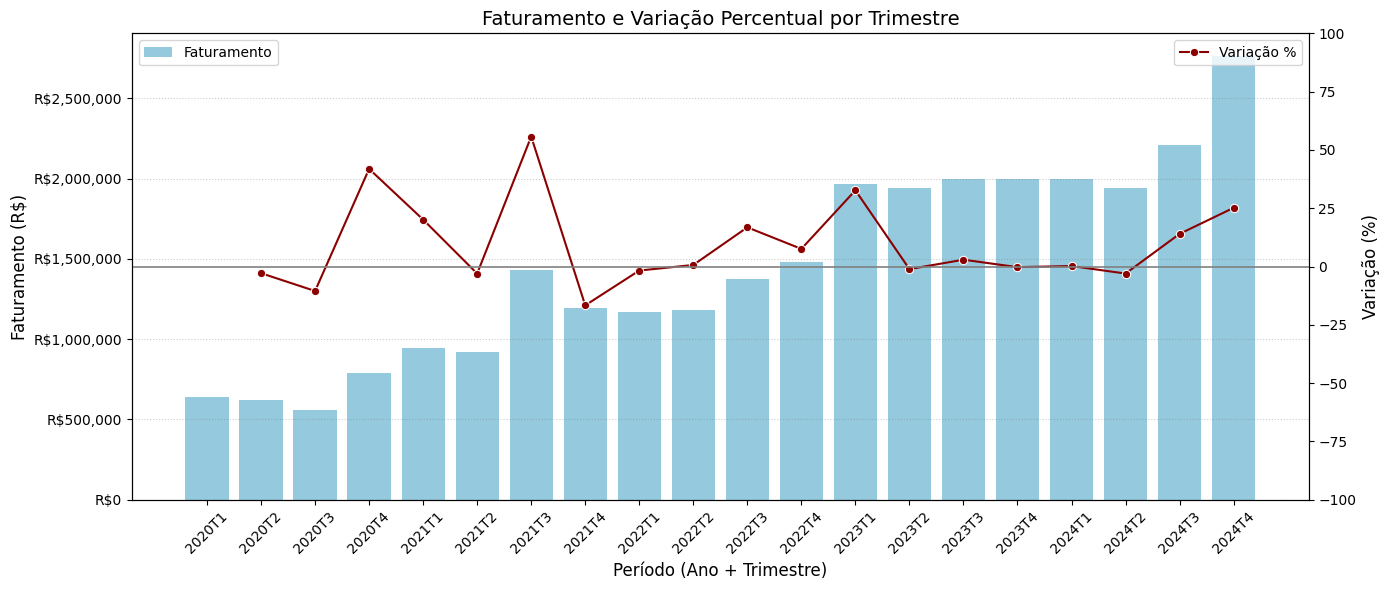

In [770]:
# Criar coluna combinada para eixo X
vendas_trimestre['Período'] = vendas_trimestre['Ano'].astype(str) + 'T' + vendas_trimestre['Trimestre'].astype(str)

# Iniciar figura e primeiro eixo
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plotar gráfico de barras (faturamento)
sns.barplot(
    data=vendas_trimestre,
    x='Período',
    y='Valor da Venda',
    ax=ax1,
    color='skyblue',
    label='Faturamento'
)

ax1.set_ylabel('Faturamento (R$)', fontsize=12)
ax1.set_xlabel('Período (Ano + Trimestre)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

# Criar segundo eixo Y
ax2 = ax1.twinx()

# Plotar gráfico de linha (variação)
sns.lineplot(
    data=vendas_trimestre,
    x='Período',
    y='Variacao',
    ax=ax2,
    color='darkred',
    marker='o',
    label='Variação %'
)
ax2.set_ylabel('Variação (%)', fontsize=12)
ax2.set_ylim(-100, 100)
ax1.grid(True, linestyle=':', color='gray', alpha=0.4, axis='y')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1.2)
# Título e legenda
plt.title('Faturamento e Variação Percentual por Trimestre', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('plots/fat_tri.jpg', bbox_inches='tight')

plt.tight_layout()
plt.show()

## Critical Analysis

In [771]:
ticket_produto.sort_values(by='total_vendas', ascending=False).head(3)

,Produto,total_vendas,quantidade_vendas,ticket_medio
33,Smartphone Motorola Edge 40,1860683,99,18794.78
27,Notebook Dell Inspiron,1773000,76,23328.95
29,Placa de Vídeo Nvidia RTX 4060,1650512,131,12599.33


In [772]:
ticket_produto.sort_values(by='quantidade_vendas', ascending=False).head(3)

,Produto,total_vendas,quantidade_vendas,ticket_medio
7,Calça Legging Nike Pro,281680,204,1380.78
40,Ventilador Mondial 40cm,184800,195,947.69
8,Carregador Portátil Anker 10000mAh,157320,181,869.17


In [773]:
vendedor = df_completed.groupby('Vendedor').agg(
    total_vendas=('Valor da Venda', 'sum'),
    quantidade_vendas=('Valor da Venda', 'count')
).reset_index().sort_values(by="total_vendas", ascending=False)
vendedor["media_por_venda"] = (vendedor["total_vendas"] / vendedor["quantidade_vendas"]).apply(lambda x: round(x, ndigits=2))

In [774]:
vendedor.sort_values(by="media_por_venda", ascending=False)

,Vendedor,total_vendas,quantidade_vendas,media_por_venda
1,Antônio,3379023,621,5441.26
0,Alice,3249026,617,5265.84
7,Maitê,2911977,554,5256.28
6,Laura,2832246,567,4995.14
5,Helena,2926880,594,4927.41
3,Cecília,3107879,632,4917.53
9,Samuel,2972127,616,4824.88
8,Miguel,2677304,588,4553.24
2,Artur,2611266,582,4486.71
4,Davi,2460681,587,4191.96


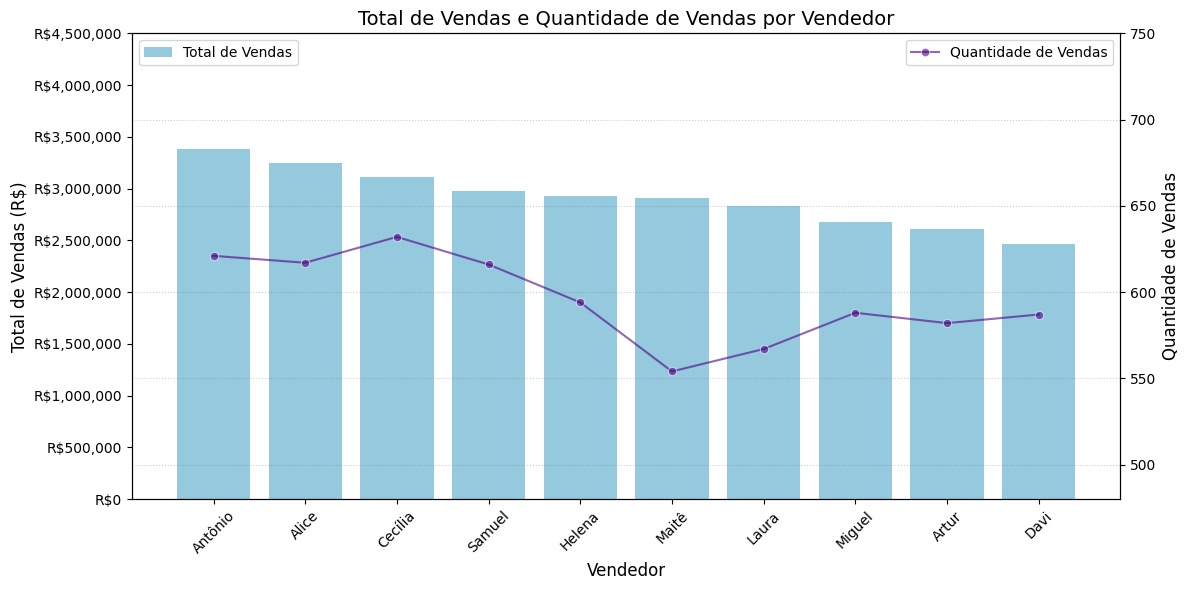

In [775]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras: total de vendas
sns.barplot(
    data=vendedor,
    x='Vendedor',
    y='total_vendas',
    ax=ax1,
    color='skyblue',
    label='Total de Vendas'
)
ax1.set_ylabel('Total de Vendas (R$)', fontsize=12)
ax1.set_xlabel('Vendedor', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

# Criar o segundo eixo Y para quantidade de vendas
ax2 = ax1.twinx()

# Gráfico de linha: quantidade de vendas
sns.lineplot(
    data=vendedor,
    x='Vendedor',
    y='quantidade_vendas',
    ax=ax2,
    color='indigo',
    marker='o',
    label='Quantidade de Vendas',
    alpha=0.6
)
ax2.set_ylabel('Quantidade de Vendas', fontsize=12)
ax2.grid(True, linestyle=':', color='gray', alpha=0.4, axis='y')
ax2.set_ylim(480, 750)
ax1.set_ylim(0, 4.5e6)

# Título e legenda
plt.title('Total de Vendas e Quantidade de Vendas por Vendedor', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/vendedor.jpg', bbox_inches='tight')
plt.show()

In [776]:
df["Nao_completada"] = df["Status do Pedido"].isin(["Em Atraso", "Cancelado"])
regiao = df.groupby('Região').agg(
    not_completed=('Nao_completada', 'sum'),
    total=('Nao_completada', 'count')
).reset_index()
regiao["percentage_not_completed"] = regiao["not_completed"] / regiao["total"] * 100

In [777]:
regiao

,Região,not_completed,total,percentage_not_completed
0,Centro-Oeste,86,653,13.169985
1,Nordeste,350,2337,14.976466
2,Norte,108,676,15.976331
3,Sudeste,548,3625,15.117241
4,Sul,217,1282,16.926677


In [778]:
vendas_trimestre = df_completed.groupby(['Ano', 'Trimestre', 'Categoria do Produto'])['Valor da Venda'].sum().reset_index()
vendas_trimestre = vendas_trimestre.sort_values(by=['Ano', 'Trimestre', 'Categoria do Produto'])
anos = df_completed['Ano'].unique()
trimestres = [1, 2, 3, 4]
categorias = df_completed['Categoria do Produto'].unique()
combinacoes = pd.DataFrame(
    list(itertools.product(anos, trimestres, categorias)),
    columns=['Ano', 'Trimestre', 'Categoria do Produto']
)
vendas_completas = combinacoes.merge(vendas_trimestre, on=['Ano', 'Trimestre', 'Categoria do Produto'], how='left')
vendas_completas['Valor da Venda'] = vendas_completas['Valor da Venda'].fillna(0)
vendas_completas=vendas_completas.sort_values(by=['Ano', 'Trimestre', 'Categoria do Produto'], ascending=True)
vendas_completas['Variacao'] = vendas_completas['Valor da Venda'].pct_change(periods=len(categorias)).apply(lambda x: round(x*100, 2))
vendas_completas=vendas_completas.sort_values(by=['Ano', 'Trimestre', 'Categoria do Produto'], ascending=False)
vendas_completas = vendas_completas.head(len(categorias))
vendas_completas

,Ano,Trimestre,Categoria do Produto,Valor da Venda,Variacao
79,2024,4,Áudio,116730,5.03
78,2024,4,Vestuário,100540,23.54
83,2024,4,Telefonia,505489,103.45
86,2024,4,Periféricos,72430,6.15
85,2024,4,Informática,445034,24.32
87,2024,4,Impressoras,130537,24.11
82,2024,4,Esportes,244886,-19.64
84,2024,4,Eletrônicos,676731,69.24
81,2024,4,Eletroportáteis,113070,20.90
80,2024,4,Eletrodomésticos,266940,-25.31


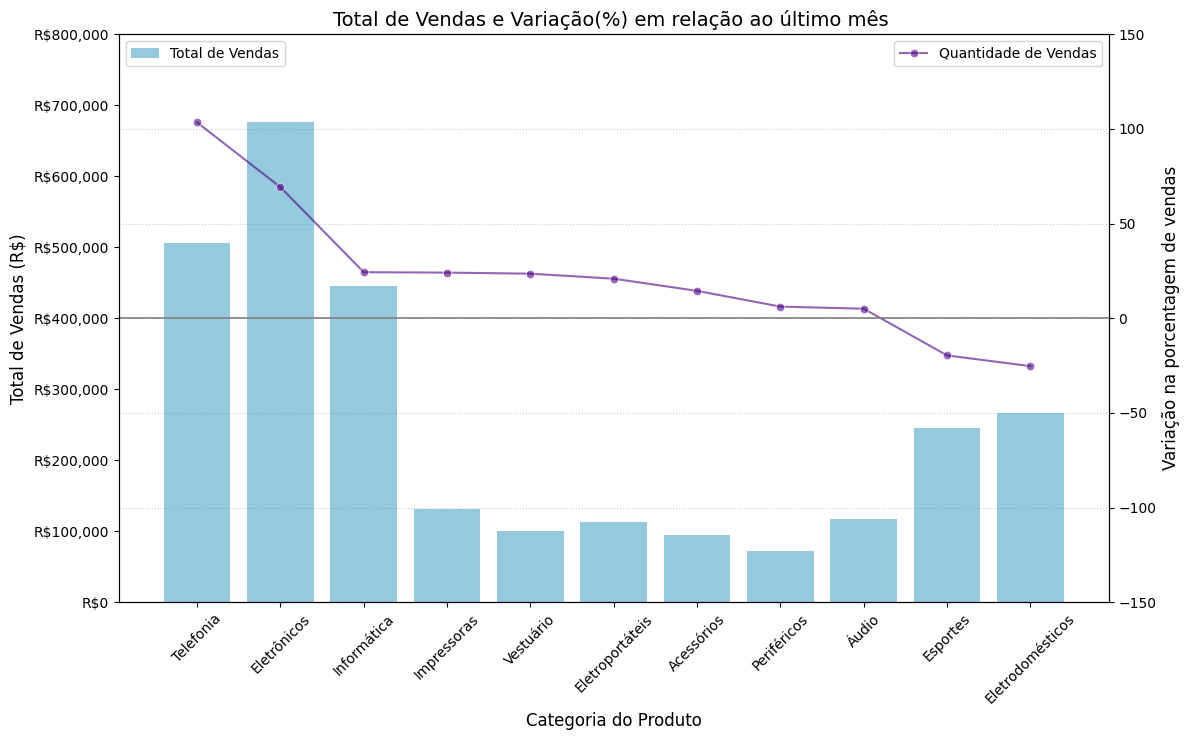

In [779]:
fig, ax1 = plt.subplots(figsize=(12, 7.5))
vendas_completas = vendas_completas.sort_values(by='Variacao', ascending=False)
sns.barplot(
    data=vendas_completas,
    x='Categoria do Produto',
    y='Valor da Venda',
    ax=ax1,
    color='skyblue',
    label='Total de Vendas'
)
ax1.set_ylabel('Total de Vendas (R$)', fontsize=12)
ax1.set_xlabel('Categoria do Produto', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

ax2 = ax1.twinx()

sns.lineplot(
    data=vendas_completas,
    x='Categoria do Produto',
    y='Variacao',
    ax=ax2,
    color='indigo',
    marker='o',
    label='Quantidade de Vendas',
    alpha=0.6
)
ax2.set_ylabel('Variação na porcentagem de vendas', fontsize=12)
ax2.grid(True, linestyle=':', color='gray', alpha=0.4, axis='y')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1.2)

ax2.set_ylim(-150, 150)
ax1.set_ylim(0, 8e5)

# Título e legenda
plt.title('Total de Vendas e Variação(%) em relação ao último mês ', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/variaca_vendas_ultimo_mes.jpg', bbox_inches='tight')
plt.show()

---

#### for some plots consider only completed sales

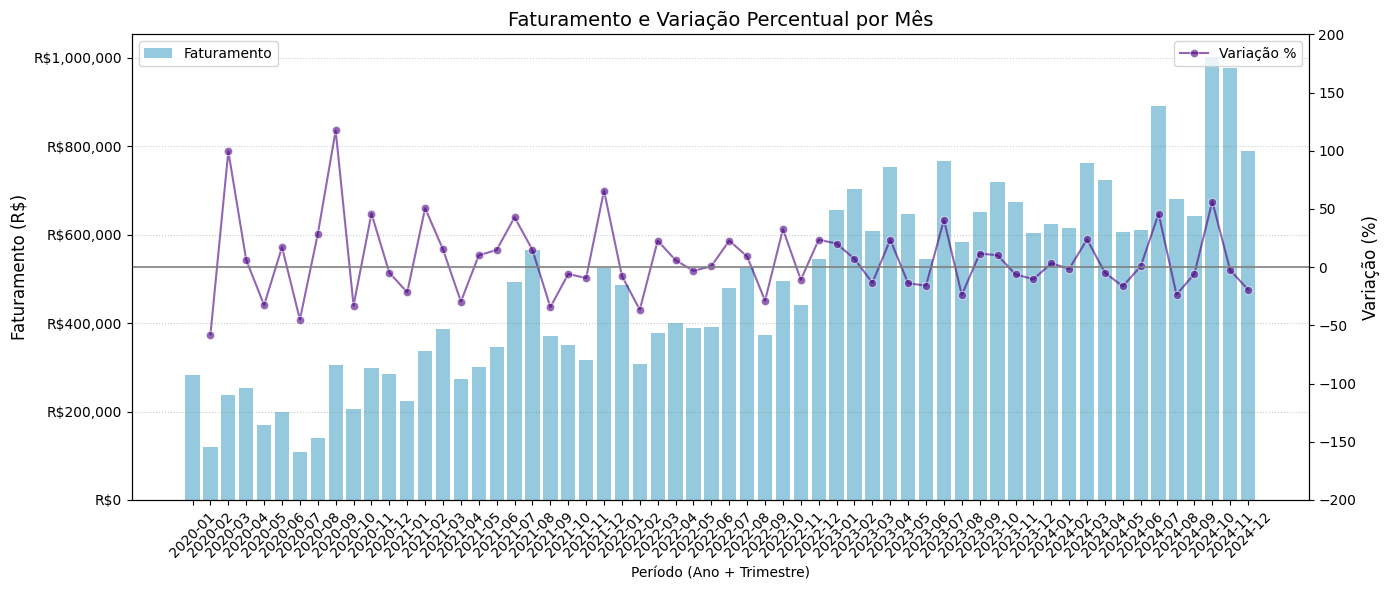

In [780]:
df_completed['AnoMes'] = df_completed['Data da Venda'].dt.to_period('M').astype(str)
faturamento_mensal = df_completed.groupby('AnoMes')['Valor da Venda'].sum().reset_index()

faturamento_mensal = faturamento_mensal.sort_values(by=['AnoMes'])
faturamento_mensal['Variacao'] = faturamento_mensal['Valor da Venda'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(14, 6))

sns.barplot(
    data=faturamento_mensal,
    x='AnoMes',
    y='Valor da Venda',
    ax=ax1,
    color='skyblue',
    label='Faturamento'
)

ax1.set_ylabel('Faturamento (R$)', fontsize=12)
ax1.set_xlabel('Período (Ano + Trimestre)', fontsize=10)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

ax2 = ax1.twinx()

sns.lineplot(
    data=faturamento_mensal,
    x='AnoMes',
    y='Variacao',
    ax=ax2,
    color='indigo',
    marker='o',
    label='Variação %',
    alpha=0.6,
)
ax2.set_ylabel('Variação (%)', fontsize=12)
ax2.set_ylim(-200, 200)
ax1.grid(True, linestyle=':', color='gray', alpha=0.4, axis='y')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1.2)
plt.title('Faturamento e Variação Percentual por Mês', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('plots/fat_mes.jpg', bbox_inches='tight')
plt.tight_layout()
plt.show()

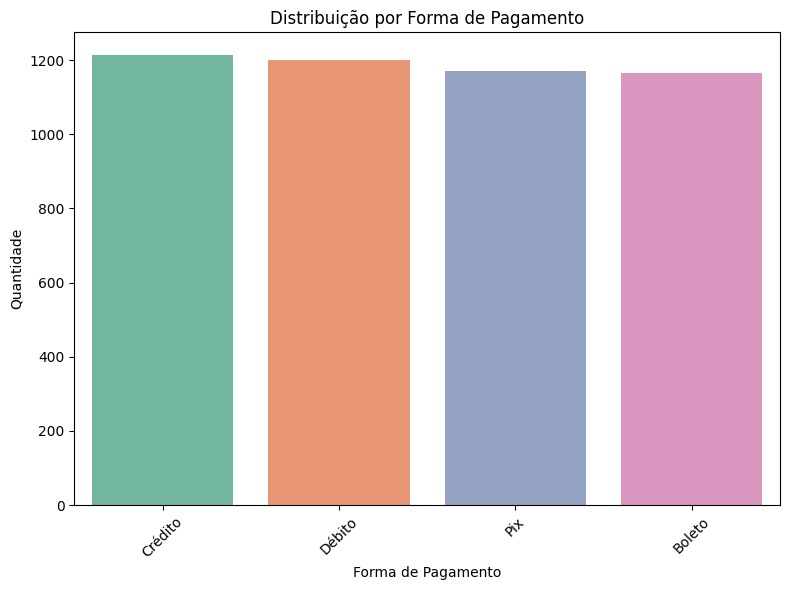

In [781]:
pagamento = df_completed['Forma de Pagamento'].value_counts().reset_index()
pagamento.columns = ['Forma de Pagamento', 'Quantidade']

plt.figure(figsize=(8,6))
sns.barplot(data=pagamento, x='Forma de Pagamento', y='Quantidade', palette="Set2", hue='Forma de Pagamento')
plt.title('Distribuição por Forma de Pagamento')
plt.xlabel('Forma de Pagamento')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/dist_forma_pagamento.jpg', bbox_inches='tight')
plt.show()

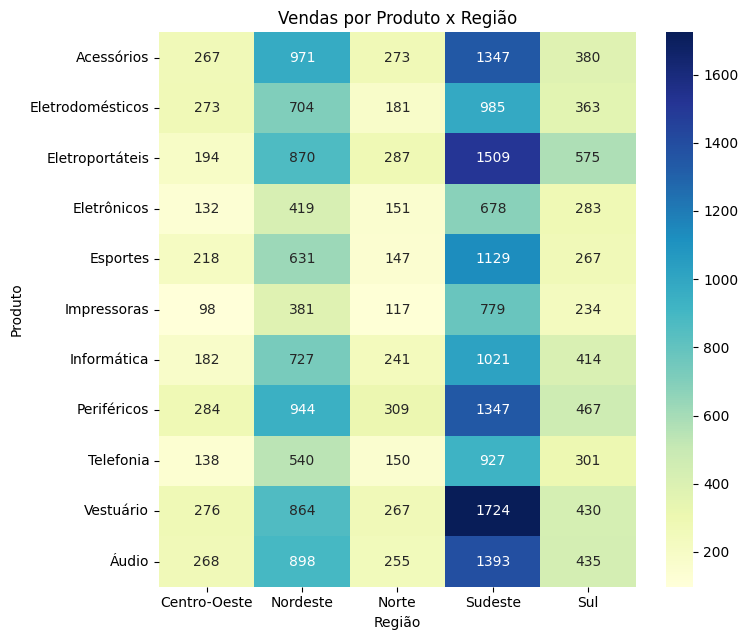

In [782]:
heatmap_data = df_completed.pivot_table(
    values='Quantidade Vendida', 
    index='Categoria do Produto', 
    columns='Região', 
    aggfunc='sum', 
    fill_value=0
)
plt.figure(figsize=(7.75, 6.5))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Vendas por Produto x Região')
plt.xlabel('Região')
plt.ylabel('Produto')
plt.tight_layout()
plt.savefig('plots/heat_map_vol_venda_regiao.jpg', bbox_inches='tight')
plt.show()

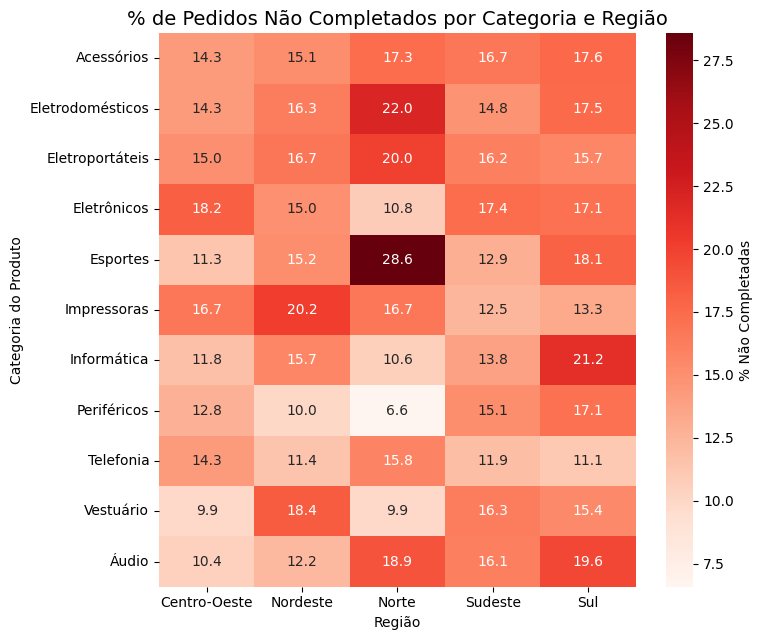

In [783]:
heatmap_data = (
    df.groupby(['Categoria do Produto', 'Região'])['Nao_completada']
    .mean()  # mean of bool gives proportion of True
    .unstack(fill_value=0) * 100  # convert to percentage
)

# 2. Plot heatmap
plt.figure(figsize=(7.75, 6.5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    cbar_kws={'label': '% Não Completadas'}
)

plt.title('% de Pedidos Não Completados por Categoria e Região', fontsize=14)
plt.xlabel('Região')
plt.ylabel('Categoria do Produto')
plt.tight_layout()
plt.savefig('plots/heat_map_vol_canc_regiao.jpg', bbox_inches='tight')
plt.show()

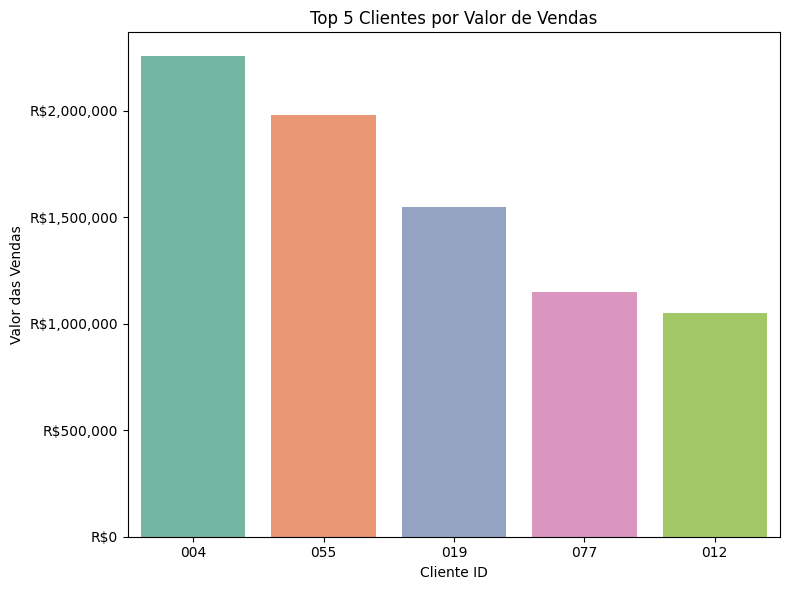

In [784]:
ranking_clientes = df_completed.groupby('Cliente_ID')['Valor da Venda'].sum().reset_index()

ranking_top5 = ranking_clientes.sort_values(by='Valor da Venda', ascending=False).head(5)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=ranking_top5, x='Cliente_ID', y='Valor da Venda', hue='Cliente_ID', palette="Set2")
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
plt.title('Top 5 Clientes por Valor de Vendas')
plt.xlabel('Cliente ID')
plt.ylabel('Valor das Vendas')
plt.tight_layout()
plt.savefig('plots/top5_clientes.jpg', bbox_inches='tight')
plt.show()

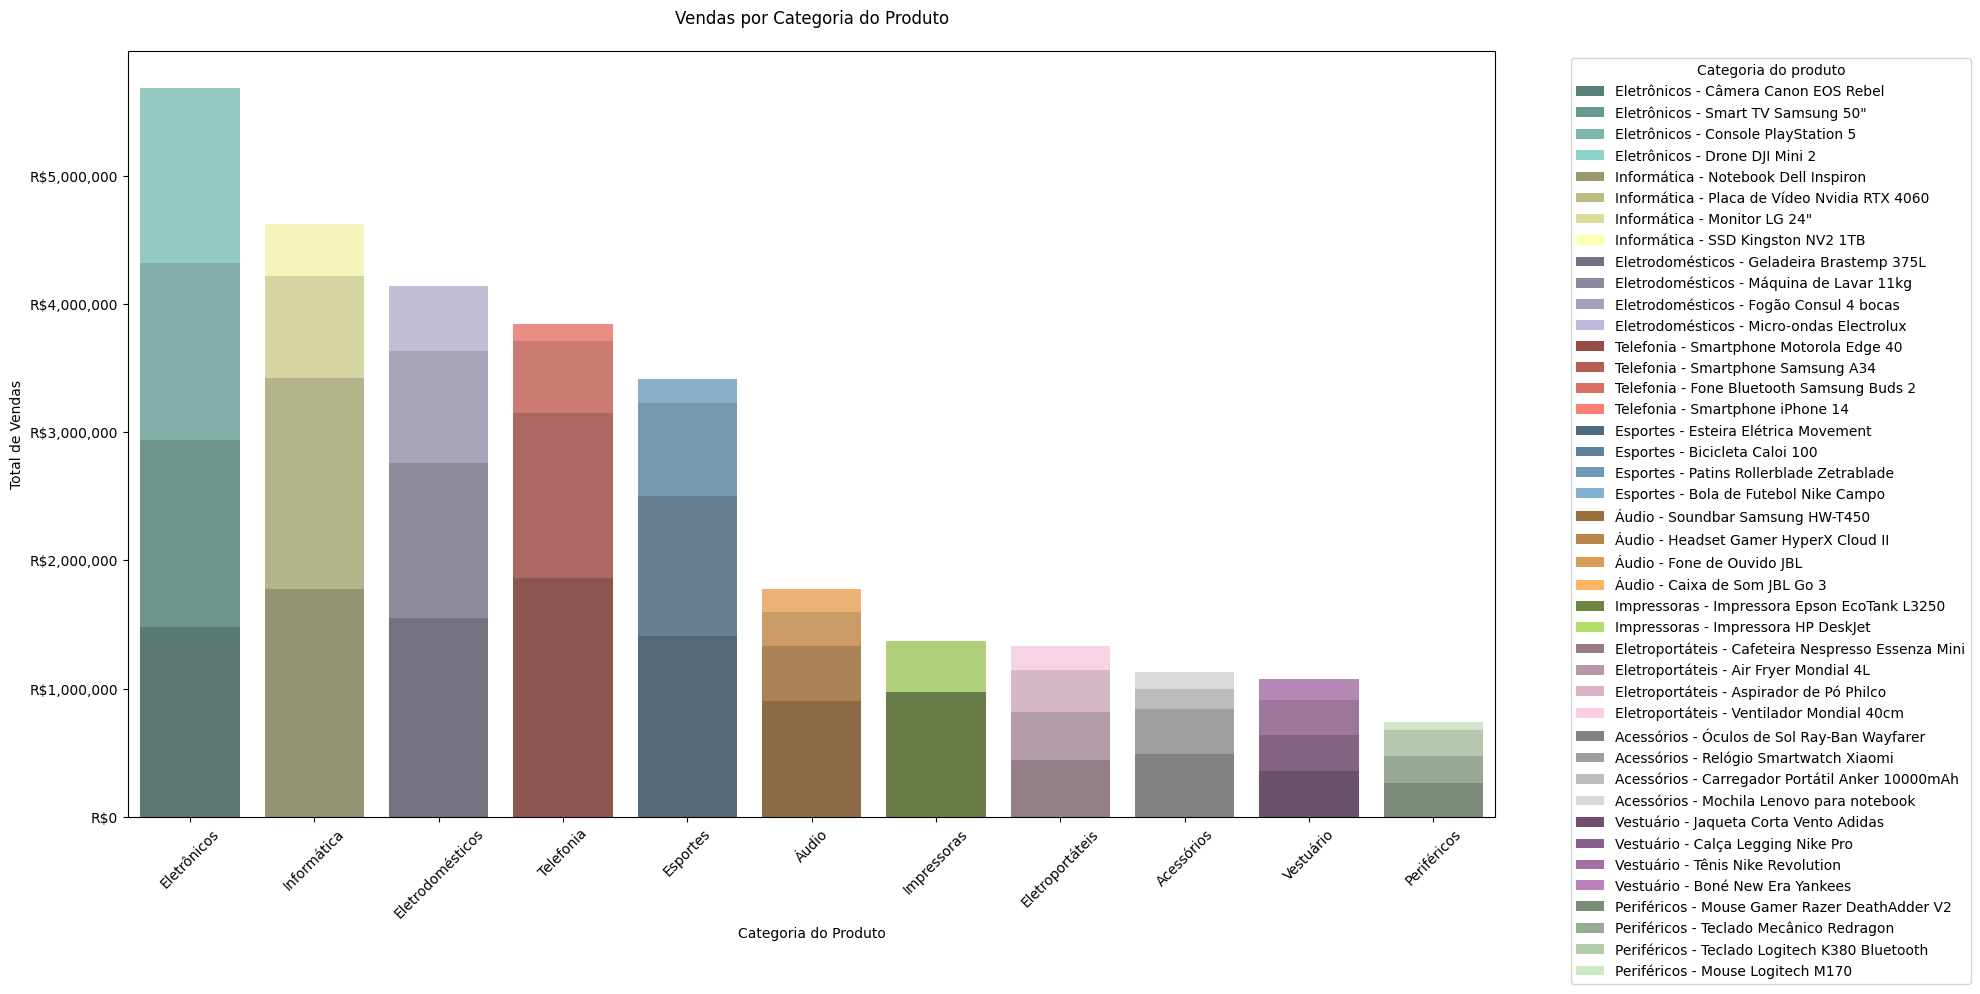

In [785]:
# Aggregate and sort data
df_agg = df_completed.groupby(['Categoria do Produto', 'Produto'])['Valor da Venda'].sum().unstack()

# Sort categories by total sales
category_order = df_agg.sum(axis=1).sort_values(ascending=False).index
df_agg = df_agg.loc[category_order]

# Sort products within each categorydf_agg
for category in df_agg.index:
    product_order = df_agg.loc[category].dropna().sort_values(ascending=False).index
    df_agg.loc[category, product_order] = df_agg.loc[category, product_order].values

# Prepare data for plotting (convert to long format)
plot_df = df_agg.reset_index().melt(id_vars='Categoria do Produto', 
                                   var_name='Produto', 
                                   value_name='Valor da Venda')
# We'll use seaborn's barplot but need to handle stacking manually
# First sort the data properly
plot_df = plot_df.join(df_venda_per_cat, on='Categoria do Produto')
plot_df = plot_df.sort_values(['total_vendas', 'Valor da Venda'], ascending=[False, False])

# Remove NA values that came from unstacking
plot_df = plot_df.dropna()

# Create color gradients for each category using Set3
n_categories = len(plot_df['Categoria do Produto'].unique())
set3_colors = plt.cm.Set3(np.linspace(0, 1, n_categories+1))[:n_categories]  # First 11 colors

category_colors = {cat: set3_colors[i] for i, cat in enumerate(plot_df['Categoria do Produto'].unique())}

# Create a color palette with gradients within each category
palette = []
for category in plot_df['Categoria do Produto'].unique():
    base_color = category_colors[category]
    products = plot_df[plot_df['Categoria do Produto'] == category]['Produto'].unique()
    n_products = len(products)
    
    # Create gradient from dark to light
    if n_products > 1:
        gradient = np.linspace(0.6, 1.0, n_products)  # dark to light
    else:
        gradient = [0.8]  # medium shade if only one product
    
    for val in gradient:
        adjusted = tuple([x * val for x in base_color[:3]])  # Only use RGB, ignore alpha
        palette.append(adjusted)

# Create mapping from (category, product) to color
color_dict = {}
idx = 0
for category in plot_df['Categoria do Produto'].unique():
    products = plot_df[plot_df['Categoria do Produto'] == category]['Produto'].unique()
    for product in products:
        color_dict[(category, product)] = palette[idx]
        idx += 1

# Create the plot
plt.figure(figsize=(20, 10))

# Create stacked bars
bottom = pd.Series(0, index=plot_df['Categoria do Produto'].unique())
for product in plot_df['Produto'].unique():
    subset = plot_df[plot_df['Produto'] == product]
    colors = [color_dict[(cat, product)] for cat in subset['Categoria do Produto']]
    ax=sns.barplot(data=subset, x='Categoria do Produto', y='Valor da Venda', color=colors[0], 
                bottom=bottom[subset['Categoria do Produto']], label=product)
    bottom[subset['Categoria do Produto']] += subset['Valor da Venda'].values

# Customize the plot
plt.title('Vendas por Categoria do Produto', pad=20)
formatter = mticker.StrMethodFormatter('R${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)
plt.xlabel('Categoria do Produto')
plt.ylabel('Total de Vendas')

# Create custom legend
handles = []
for (cat, prod), color in color_dict.items():
    handles.append(plt.Rectangle((0,0), 1, 1, fc=color, label=f"{cat} - {prod}"))
plt.legend(handles=handles, title='Categoria do produto', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/venda_por_categoria.jpg', bbox_inches='tight')
plt.show()

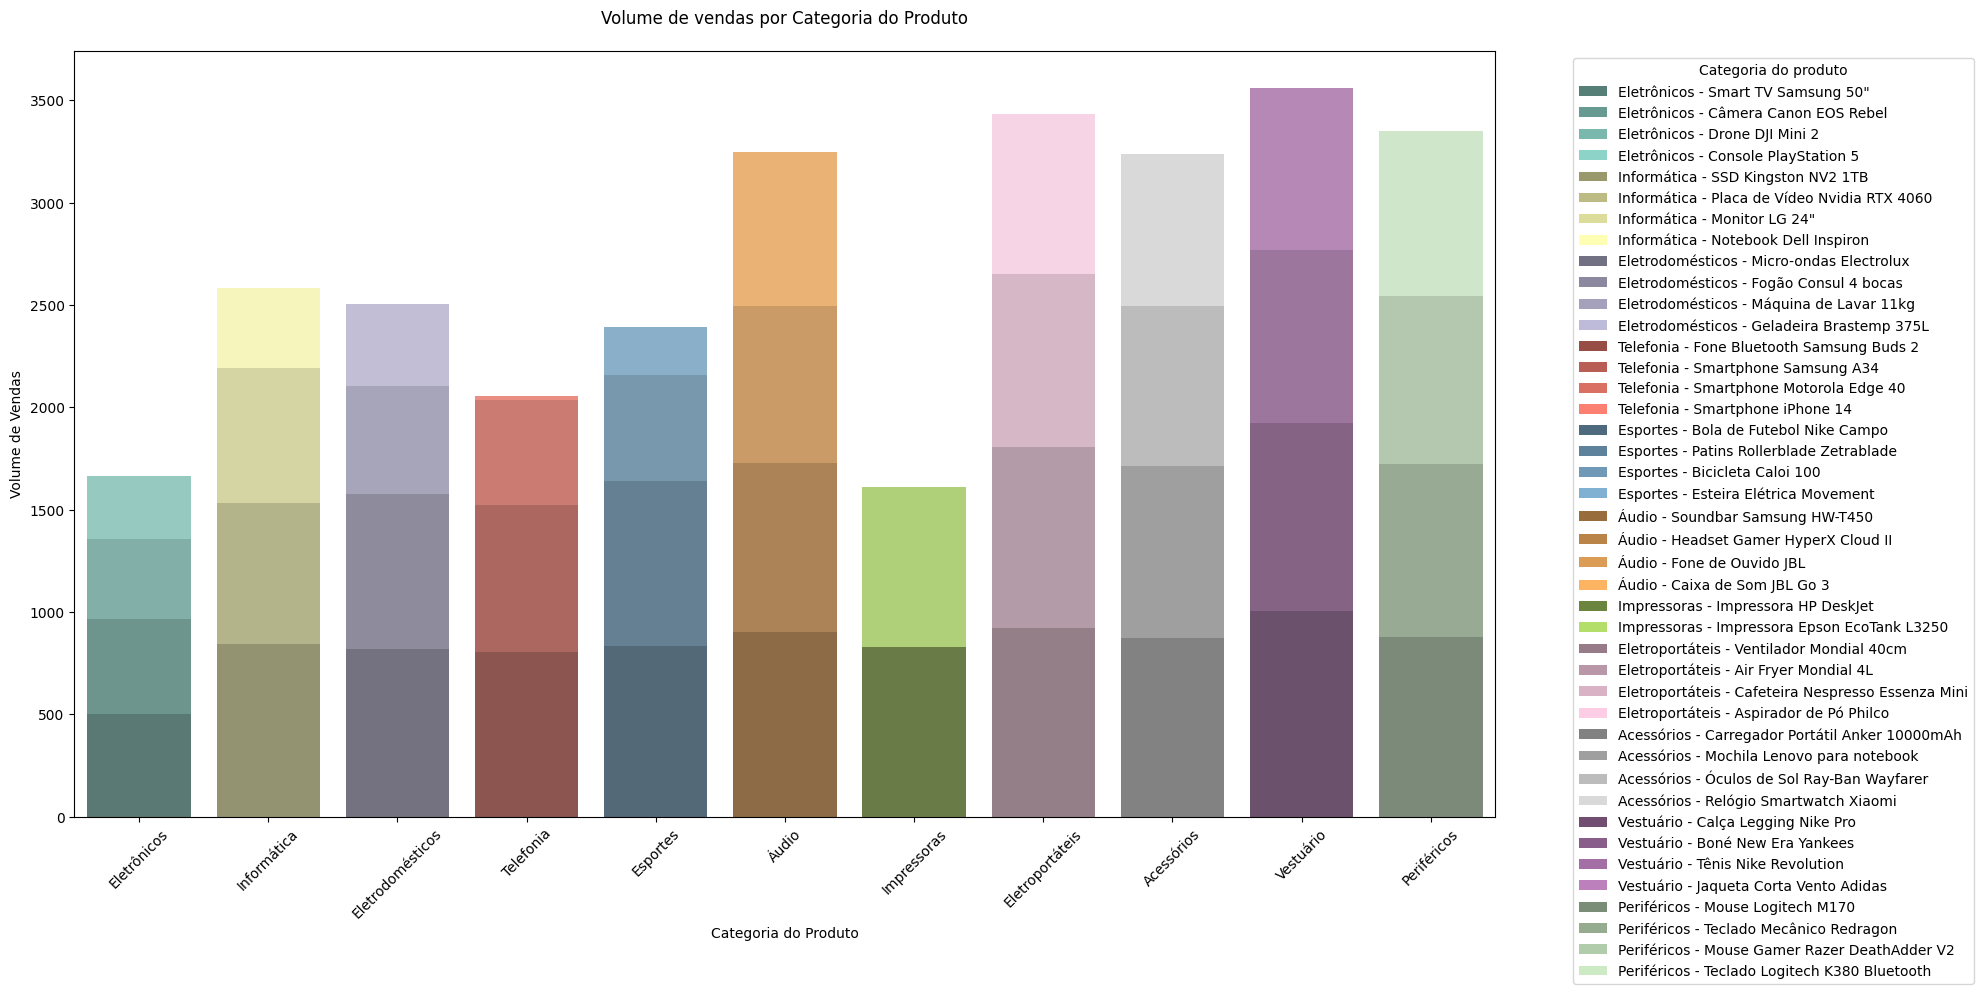

In [786]:
df_vol_per_cat = df_completed.groupby('Categoria do Produto').agg(
    total_vendas=('Quantidade Vendida', 'sum'),
    total_value=('Valor da Venda', 'sum')
).sort_values(by="total_value", ascending=False)

# Aggregate and sort data
df_agg = df_completed.groupby(['Categoria do Produto', 'Produto'])['Quantidade Vendida'].sum().unstack()

# # Sort categories by total sales
# category_order = df_agg.sum(axis=1).sort_values(ascending=False).index
# print(category_order)
# df_agg = df_agg.loc[category_order]

# # Sort products within each category
# for category in df_agg.index:
#     product_order = df_agg.loc[category].dropna().sort_values(ascending=False).index
#     df_agg.loc[category, product_order] = df_agg.loc[category, product_order].values

# Prepare data for plotting (convert to long format)
plot_df = df_agg.reset_index().melt(id_vars='Categoria do Produto', 
                                   var_name='Produto', 
                                   value_name='Quantidade Vendida')
# We'll use seaborn's barplot but need to handle stacking manually
# First sort the data properly
plot_df = plot_df.join(df_vol_per_cat, on='Categoria do Produto')
plot_df = plot_df.sort_values(['total_value', 'Quantidade Vendida'], ascending=[False, False])

# Remove NA values that came from unstacking
plot_df = plot_df.dropna()

# Create color gradients for each category using Set3
n_categories = len(plot_df['Categoria do Produto'].unique())
set3_colors = plt.cm.Set3(np.linspace(0, 1, n_categories+1))[:n_categories]  # First 11 colors

category_colors = {cat: set3_colors[i] for i, cat in enumerate(plot_df['Categoria do Produto'].unique())}

# Create a color palette with gradients within each category
palette = []
for category in plot_df['Categoria do Produto'].unique():
    base_color = category_colors[category]
    products = plot_df[plot_df['Categoria do Produto'] == category]['Produto'].unique()
    n_products = len(products)
    
    # Create gradient from dark to light
    if n_products > 1:
        gradient = np.linspace(0.6, 1.0, n_products)  # dark to light
    else:
        gradient = [0.8]  # medium shade if only one product
    
    for val in gradient:
        adjusted = tuple([x * val for x in base_color[:3]])  # Only use RGB, ignore alpha
        palette.append(adjusted)

# Create mapping from (category, product) to color
color_dict = {}
idx = 0
for category in plot_df['Categoria do Produto'].unique():
    products = plot_df[plot_df['Categoria do Produto'] == category]['Produto'].unique()
    for product in products:
        color_dict[(category, product)] = palette[idx]
        idx += 1

# Create the plot
plt.figure(figsize=(20, 10))

# Create stacked bars
bottom = pd.Series(0, index=plot_df['Categoria do Produto'].unique())
for product in plot_df['Produto'].unique():
    subset = plot_df[plot_df['Produto'] == product]
    colors = [color_dict[(cat, product)] for cat in subset['Categoria do Produto']]
    ax=sns.barplot(data=subset, x='Categoria do Produto', y='Quantidade Vendida', color=colors[0], 
                bottom=bottom[subset['Categoria do Produto']], label=product)
    bottom[subset['Categoria do Produto']] += subset['Quantidade Vendida'].values

# Customize the plot
plt.title('Volume de vendas por Categoria do Produto', pad=20)
plt.xlabel('Categoria do Produto')
plt.ylabel('Volume de Vendas')

# Create custom legend
handles = []
for (cat, prod), color in color_dict.items():
    handles.append(plt.Rectangle((0,0), 1, 1, fc=color, label=f"{cat} - {prod}"))
plt.legend(handles=handles, title='Categoria do produto', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/vol_por_categoria.jpg', bbox_inches='tight')
plt.show()